In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import imagej
import scyjava as sj
import numpy as np
import random
import time

# ImageJ initialisieren
ij = imagej.init('sc.fiji:fiji')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.15.0/1.54f


In [2]:
# Pfade definieren
image_folder_path = r'D:\Studium\Master\Masterarbeit\Code\DL\02_Cropped Images'
watershed_folder_path = os.path.join(image_folder_path, 'watershed_images')

# Erstellen des neuen Unterordners für Watershed-Bilder
os.makedirs(watershed_folder_path, exist_ok=True)


In [5]:
# Initialisierung der Variablen für die Gesamtergebnisse
total_cell_areas_mm2 = []
total_cell_diameters_mm = []
total_wall_thicknesses = []
processed_images_count = 0

# Liste der bearbeiteten Bilder
processed_images = []


In [7]:
# Startzeit festhalten
start_time = time.time()

# Durch alle Bilder im Ordner iterieren
for filename in os.listdir(image_folder_path):
    if filename.endswith(".tif"):
        image_path = os.path.join(image_folder_path, filename)
        img_crop = cv2.imread(image_path)

        # Bild in eine binäre Maske konvertieren
        gray_image = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        inverted_binary_mask = cv2.bitwise_not(binary_mask)

        # Invertierte binäre Maske in ein ImageJ-Objekt konvertieren
        imagej_object = ij.py.to_imageplus(inverted_binary_mask)
        imagej_object.updateAndDraw()

        # Prozessor des Bildes erhalten
        ip = imagej_object.getProcessor()

        # EDM importieren
        EDM = sj.jimport('ij.plugin.filter.EDM')
        edm = EDM()

        # Überprüfen, ob das Bild binär ist
        if not ip.isBinary():
            ij.IJ().log("8-bit binary image (0 and 255) required.")
        else:
            edm.setup("watershed", None)
            edm.run(ip)

        # Bild nach Watershed temporär speichern
        temp_output_path = os.path.join(watershed_folder_path, f"{os.path.splitext(filename)[0]}_watershed.tif")
        ij.IJ().saveAs(imagej_object, "Tiff", temp_output_path)

        # Bild erneut öffnen
        img_Watershed = cv2.imread(temp_output_path)
        img_Watershed_binary = cv2.imread(temp_output_path, cv2.IMREAD_UNCHANGED)

        # Konturen finden
        contours, _ = cv2.findContours(img_Watershed_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Flächen der Zellen berechnen
        cell_areas_px = [cv2.contourArea(cnt) for cnt in contours]
        cell_areas_mm2 = [area * (0.025 ** 2) for area in cell_areas_px]
        total_cell_areas_mm2.extend(cell_areas_mm2)

        # Durchmesser der Zellen berechnen
        cell_diameters_mm = [np.sqrt(4 * area / np.pi) for area in cell_areas_mm2]
        total_cell_diameters_mm.extend(cell_diameters_mm)

        # Distanztransformation anwenden
        mask = cv2.bitwise_not(img_Watershed_binary)
        dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
        wall_thicknesses = dist_transform[img_Watershed_binary == 0]
        total_wall_thicknesses.extend(wall_thicknesses * 0.025)  # Umrechnung von Pixel in mm

        # Anzahl der bearbeiteten Bilder erhöhen
        processed_images_count += 1
        processed_images.append((img_crop, img_Watershed_binary, contours))
        
        # Gesamtfläche des Bildes berechnen
        total_area_px = img_Watershed_binary.shape[0] * img_Watershed_binary.shape[1]
        total_area_mm2 = total_area_px * (0.025 ** 2)  # Umrechnung von Pixel in mm²

        # Verhältnis der Zellenfläche zur Gesamtfläche berechnen
        total_cell_area_mm2 = sum(cell_areas_mm2)
        cell_area_ratio = total_cell_area_mm2 / total_area_mm2        


# Endzeit festhalten
end_time = time.time()

# Verstrichene Zeit berechnen
elapsed_time = end_time - start_time
elapsed_minutes = int(elapsed_time // 60)
elapsed_seconds = elapsed_time % 60

print(f"Anzahl der bearbeiteten Bilder: {processed_images_count}")
print(f"Verstrichene Zeit: {elapsed_minutes} Minuten und {elapsed_seconds:.2f} Sekunden")

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the IJ class will not be fully functional.


Anzahl der bearbeiteten Bilder: 1242
Verstrichene Zeit: 1 Minuten und 55.38 Sekunden


In [11]:
# Gesamtergebnisse berechnen
average_cell_area_mm2 = np.mean(total_cell_areas_mm2) if total_cell_areas_mm2 else 0
largest_cell_area_mm2 = np.max(total_cell_areas_mm2) if total_cell_areas_mm2 else 0
mean_cell_diameter_mm = np.mean(total_cell_diameters_mm) if total_cell_diameters_mm else 0
max_cell_diameter_mm = np.max(total_cell_diameters_mm) if total_cell_diameters_mm else 0
mean_wall_thickness = np.mean(total_wall_thicknesses) if total_wall_thicknesses else 0
max_wall_thickness = np.max(total_wall_thicknesses) if total_wall_thicknesses else 0

# Anforderungen nach EN 253 überprüfen
en253_requirement = 0.1 <= mean_cell_diameter_mm <= 0.5

# Ergebnisse ausgeben
print(f"Anzahl der bearbeiteten Bilder: {processed_images_count}")
print(f"Verhältnis der Zellenfläche zur Gesamtfläche für {filename}: {cell_area_ratio:.4f}")
print(f"Mittlere Zellenfläche: {average_cell_area_mm2:.4f} mm²")
print(f"Größte Zellenfläche: {largest_cell_area_mm2:.4f} mm²")
print(f"Durchmesser der mittleren Zelle: {mean_cell_diameter_mm:.2f} mm")
print(f"Durchmesser der größten Zelle: {max_cell_diameter_mm:.2f} mm")
if en253_requirement:
    print("Der Durchmesser der mittleren Zelle erfüllt die Anforderungen nach EN 253.")
else:
    print("Der Durchmesser der mittleren Zelle erfüllt NICHT die Anforderungen nach EN 253.")
print(f"Mittlere Wanddicke: {mean_wall_thickness:.4f} mm")
print(f"Maximale Wanddicke: {max_wall_thickness:.4f} mm")

Anzahl der bearbeiteten Bilder: 1242
Verhältnis der Zellenfläche zur Gesamtfläche für watershed_images: 0.4808
Mittlere Zellenfläche: 0.0454 mm²
Größte Zellenfläche: 5.3250 mm²
Durchmesser der mittleren Zelle: 0.21 mm
Durchmesser der größten Zelle: 2.60 mm
Der Durchmesser der mittleren Zelle erfüllt die Anforderungen nach EN 253.
Mittlere Wanddicke: 0.0322 mm
Maximale Wanddicke: 0.3248 mm


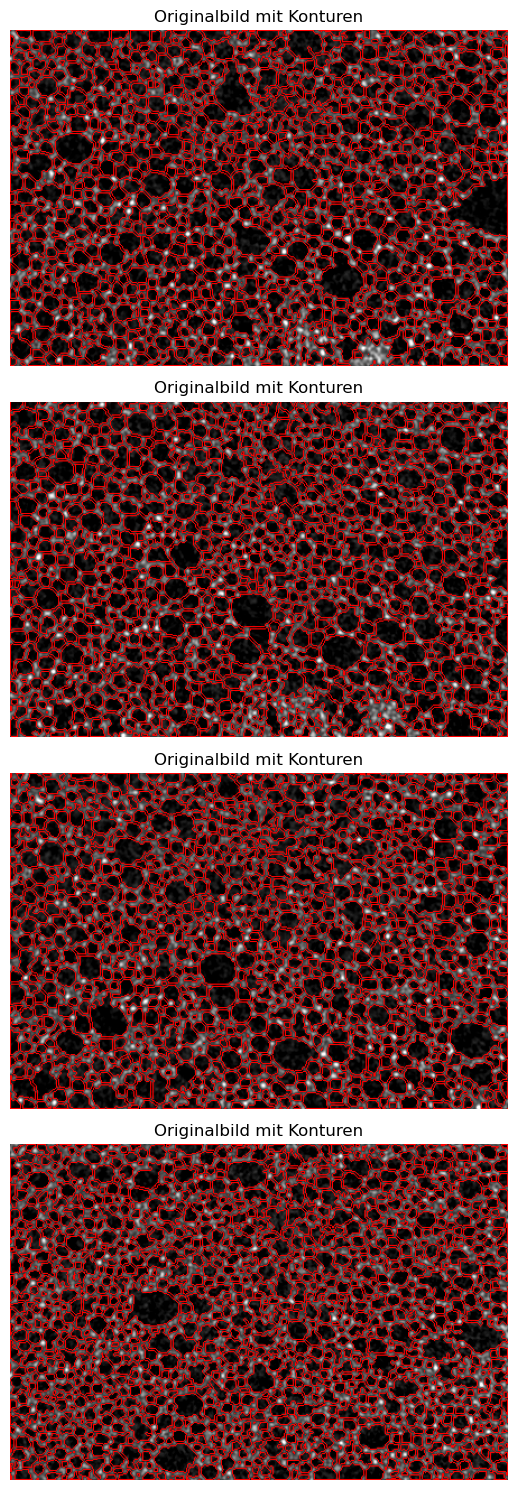

In [12]:
# Vier zufällige Bilder auswählen und anzeigen
random_images = random.sample(processed_images, 4)

fig, axes = plt.subplots(4, 1, figsize=(10, 15))
for i, (original_img, watershed_img, contours) in enumerate(random_images):
    # Konturen auf dem Originalbild zeichnen
    contour_img = original_img.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 1)
    
    # Bild anzeigen
    axes[i].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    axes[i].set_title("Originalbild mit Konturen")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

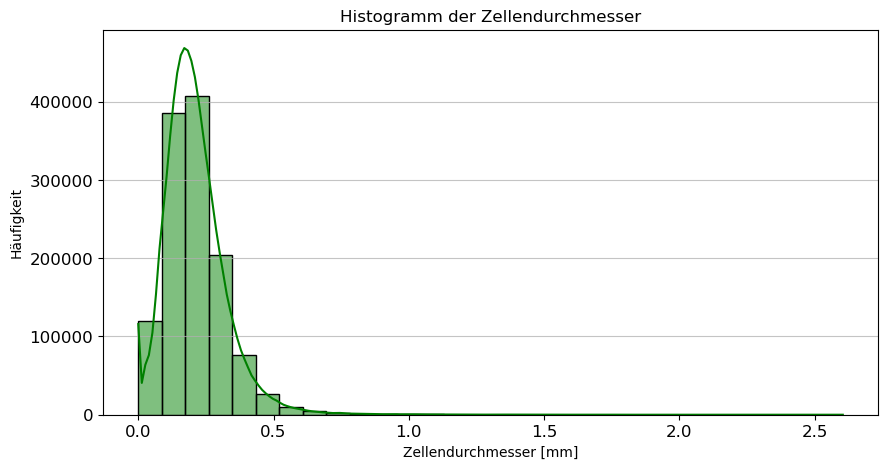

In [15]:
# Histogramm für Zellendurchmesser
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.histplot(total_cell_diameters_mm, bins=30, kde=True, color='green', edgecolor='black')
plt.xlabel('Zellendurchmesser [mm]')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Zellendurchmesser')
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

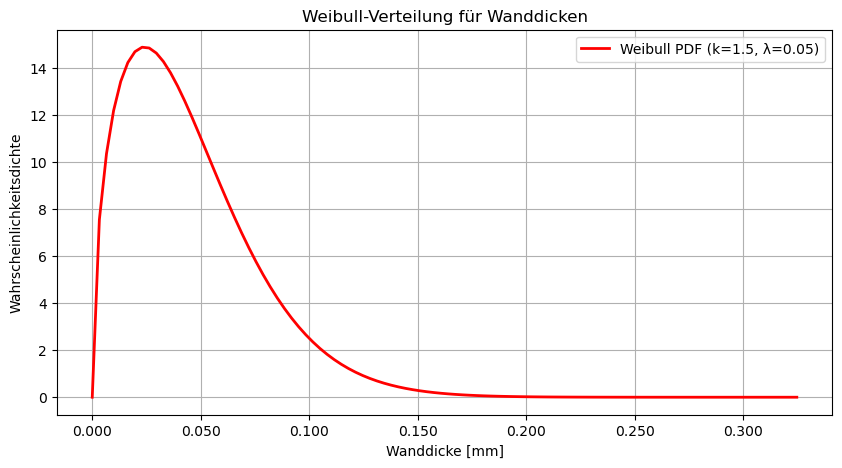

In [17]:
# Weibull-Verteilung für Wandstärke
from scipy.stats import weibull_min
k = 1.5  # Formparameter
lambda_ = 0.05  # Skalenparameter
max_wall_thickness = max(total_wall_thicknesses)
x = np.linspace(0, max_wall_thickness, 100)

plt.figure(figsize=(10, 5))
plt.plot(x, weibull_min.pdf(x, k, scale=lambda_), 'r-', lw=2, label=f'Weibull PDF (k={k}, λ={lambda_})')
plt.title('Weibull-Verteilung für Wanddicken')
plt.xlabel('Wanddicke [mm]')
plt.ylabel('Wahrscheinlichkeitsdichte')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}".format(x)))
plt.legend()
plt.grid(True)
plt.show()